In [16]:
!pip install sklearn

    100% |████████████████████████████████| 7.9MB 6.3MB/s eta 0:00:01    88% |████████████████████████████▍   | 7.0MB 61.4MB/s eta 0:00:01


In [1]:
import pandas as pd
from ast import literal_eval
import requests
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import time
import geopy
import geopy.distance
from geopy.distance import VincentyDistance
from gmplot import gmplot
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from scipy.spatial import Voronoi
from scipy.stats import multivariate_normal
from scipy.stats.distributions import norm
from sklearn.preprocessing import StandardScaler
from scipy import random, linalg, sin,cos
from scipy.stats import multivariate_normal
import scipy
import matplotlib.pyplot as plt

import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
    

In [55]:
class Pipeline:   
    
    gmm = None

    given_index=None
    a_index=None
    
    a_scales = None
    a_means = None
    
    a_mins = None
    a_maxes = None
    
    posterior_resolution= None
    
    def __init__(self,gmm,given_index,a_index,a_means,a_scales,a_mins,a_maxes,posterior_resolution=1000):
        self.gmm =gmm
        self.given_index=given_index
        self.a_index =a_index
        self.a_scales=a_scales
        self.a_means=a_means
        self.a_mins=a_mins
        self.a_maxes=a_maxes
        self.posterior_resolution=posterior_resolution
        
    def set_a(self,a_index,a_means,a_scales,a_mins,a_maxes,posterior_resolution=1000):
        self.a_index =a_index
        self.a_scales=a_scales
        self.a_means=a_means
        self.a_mins=a_mins
        self.a_maxes=a_maxes
        self.posterior_resolution=posterior_resolution

    def set_given_index(self,given_index):
        self.given_index=given_index
    
    def conditional_multivariate(self,given_val,means,covariances):
        
        cov_aa = covariances[np.ix_(self.a_index,self.a_index)]
        cov_bb = covariances[np.ix_(self.given_index,self.given_index)]
        inv_bb = np.linalg.inv(cov_bb)

        cov_ab = covariances[np.ix_(self.a_index,self.given_index)]
        cov_ba = covariances[np.ix_(self.given_index,self.a_index)]

        mean_a = means[np.ix_(self.a_index)]
        mean_b = means[np.ix_(self.given_index)]

        mean     = mean_a + np.matmul(np.matmul(cov_ab,inv_bb),(given_val-mean_b))
        variance = cov_aa - np.matmul(np.matmul(cov_ab,inv_bb),(cov_ba))

        return mean , variance


    def conditional_gmm_means_variances(self,given_val,means,covariances):

        gmm_means =[]
        gmm_variances =[]

        for i in range(len(means)):
            means, variances = self.conditional_multivariate(given_val,self.gmm.means_[i],self.gmm.covariances_[i])
            gmm_means.append(means)
            gmm_variances.append(variances)

        return gmm_means,gmm_variances

    def marg_MVnorm(self,MVnorm_obj):

        mu_b = MVnorm_obj.mean[np.ix_(self.given_index)]
        cov_bb = MVnorm_obj.cov[np.ix_(self.given_index,self.given_index)]

        if mu_b.shape[0]>=2:
            Mv_marg = multivariate_normal(mu_b,cov_bb )
        else:
            Mv_marg = norm(mu_b[0],cov_bb[0])


        return Mv_marg

    def marg_weights(self,MVnorm_objs,given_val):
        weights = []
        sum =0
        for MVnorm_obj in MVnorm_objs:
            pdf = MVnorm_obj.pdf(given_val)
            weights.append(pdf)
            sum+=pdf
        return weights/sum

    def multivariate_cdf_dif(self,MVnorm_obj,lower_bound,upper_bound):
        return MVnorm_obj.cdf(upper_bound)-MVnorm_obj.cdf(lower_bound)

    def maxSum(self,arr, n, k): 

        if (n < k): 

            print("Invalid") 
            return -1

        max_sum = 0
        start_point = 0
        for i in range(k): 
            max_sum += arr[i] 


        curr_sum = max_sum 
        for i in range(k, n): 

            curr_sum += arr[i] - arr[i-k] 
            if curr_sum > max_sum:
                max_sum=curr_sum
                start_point = i-k+1

        return max_sum,start_point 



    def get_dist_range(self,upper_bound_range,distribution,percentage):
        n = len(distribution) 
        for i in range(1,n):
            max_sum,start_point = self.maxSum(distribution, n, i)
            if max_sum>percentage:
                return upper_bound_range[start_point],upper_bound_range[start_point+i-1]
        return upper_bound_range[start_point],upper_bound_range[start_point+i-1]
        
    def get_dist_mode(self,dist_range,distribution):
        mode,mode_index=0,0
        for i in range(len(distribution)):
            if distribution[i]>mode:
                mode_index,mode=i,distribution[i]
        return dist_range[mode_index],mode_index
    
    def predict_with_cdf(self,given_val):

        conditional_mvns =[]
        conditional_means , conditional_variances = pipeline.conditional_gmm_means_variances(given_val,self.gmm.means_,self.gmm.covariances_)

        marg_mvns = []

        for i in range(len(self.gmm.means_)): 
            mvn = scipy.stats.multivariate_normal(self.gmm.means_[i],self.gmm.covariances_[i])
            marg_mvns.append(pipeline.marg_MVnorm(mvn))

        weights = pipeline.marg_weights(marg_mvns,given_val)

        for i in range(len(conditional_means)):
            conditional_mvns.append(scipy.stats.multivariate_normal(conditional_means[i],conditional_variances[i]))

        dist_range = np.linspace(self.a_mins,self.a_maxes,self.posterior_resolution)
        step_size=dist_range[1]-dist_range[0]
        lower_bound_range = dist_range[:-1]
        
        upper_bound_range = dist_range[1:]
        
        m2 = np.array([pipeline.multivariate_cdf_dif(conditional_mvns[i],lower_bound_range,upper_bound_range) for i in range(len(conditional_mvns))])
        dist = np.dot(m2.T,weights)

        dist_mode,mode_index = pipeline.get_dist_mode(dist_range,dist)
        return(dist_mode*self.a_scales+self.a_means,dist,mode_index,upper_bound_range*self.a_scales+self.a_means)


    def predict_with_pdf(self,given_val):

        conditional_mvns =[]
        conditional_means , conditional_variances = pipeline.conditional_gmm_means_variances(given_val,self.gmm.means_,self.gmm.covariances_)

        marg_mvns = []

        for i in range(len(gmm.means_)):
            mvn = scipy.stats.multivariate_normal(self.gmm.means_[i],self.gmm.covariances_[i])
            marg_mvns.append(pipeline.marg_MVnorm(mvn))

        weights = pipeline.marg_weights(marg_mvns,given_val)

        for i in range(len(conditional_means)):
            conditional_mvns.append(scipy.stats.multivariate_normal(conditional_means[i],conditional_variances[i]))

        dist_range = np.linspace(self.a_mins,self.a_maxes,self.posterior_resolution)
        step_size=dist_range[1]-dist_range[0]
        
        m = np.array([conditional_mvns[i].pdf(dist_range) for i in range(len(conditional_mvns))])
        dist = np.dot(m.T,weights)

        dist_mode,mode_index = pipeline.get_dist_mode(dist_range,dist)
        return(dist_mode*self.a_scales+self.a_means,dist,mode_index,dist_range*self.a_scales+self.a_means)
    
    def get_pdf(self,given_val):
        conditional_mvns =[]
        conditional_means , conditional_variances = pipeline.conditional_gmm_means_variances(given_val,self.gmm.means_,self.gmm.covariances_)

        marg_mvns = []

        for i in range(len(gmm.means_)):
            mvn = scipy.stats.multivariate_normal(self.gmm.means_[i],self.gmm.covariances_[i])
            marg_mvns.append(pipeline.marg_MVnorm(mvn))

        weights = pipeline.marg_weights(marg_mvns,given_val)

        for i in range(len(conditional_means)):
            conditional_mvns.append(scipy.stats.multivariate_normal(conditional_means[i],conditional_variances[i]))

        #dist_range = np.linspace(self.a_mins,self.a_maxes,self.posterior_resolution)
        #step_size=dist_range[1]-dist_range[0]
        
        m = np.array([conditional_mvns[i].pdf(dist_range) for i in range(len(conditional_mvns))])
        dist = np.dot(m.T,weights)

        #dist_mode,mode_index = pipeline.get_dist_mode(dist_range,dist)
        return(dist)

        


In [56]:
def map_coordinates(coordinates):
    lat,lon =np.array([ float(coord) for coord in coordinates.split(',')])
    x = cos(lat) * cos(lon)
    y = cos(lat) * sin(lon)
    z = sin(lat)
    return x,y,z   


In [57]:
riyadh_land = pd.read_csv("riyadh_land_with_poi.csv")
riyadh_land=riyadh_land[(riyadh_land['meter_price']<7000)&(riyadh_land['meter_price']>50)]
riyadh_land['x'],riyadh_land['y'],riyadh_land['z']=riyadh_land.location_str.map(lambda x: map_coordinates(x)[0]),riyadh_land.location_str.map(lambda x: map_coordinates(x)[1]),riyadh_land.location_str.map(lambda x: map_coordinates(x)[2])

In [58]:
all_columns = ['x','y','z','location_str','hospitals','schools','meter_price']

given_columns = ['meter_price','hospitals','schools']
a_columns = ['x','y','z']

gmm_columns=given_columns+a_columns

X = riyadh_land[all_columns]
ss = StandardScaler()

X_train, X_test= train_test_split(X, test_size=0.33, random_state=42)

X_train_location = X_train.location_str.values
X_test_location = X_test.location_str.values

y_train = X_train.meter_price
y_test  = X_test.meter_price

X_train = X_train[gmm_columns]
X_test = X_test[gmm_columns]

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

X_train=pd.DataFrame(X_train,columns=gmm_columns)
X_test=pd.DataFrame(X_test,columns=gmm_columns)


In [59]:
X_train.head()

,meter_price,hospitals,schools,x,y,z
0,-0.667289,-0.246897,-1.070419,-0.742036,0.145938,0.959383
1,0.361331,1.979300,1.223022,-0.420859,0.103036,0.374988
2,0.361331,-0.432414,0.225874,0.402285,0.941528,0.143281
3,0.875641,0.680685,0.824163,0.214727,0.504346,-0.077185
4,-0.527022,-0.617930,-0.521987,-0.435761,0.553199,0.940753


In [40]:
#here bic and aic were evaluated and elbow for penalized-likelihood criteria was found at around 80 clusters
gmm = GaussianMixture(n_components=80,max_iter=500,random_state=42).fit(X_train)

In [41]:
index_dict = {column:i for i,column in enumerate(gmm_columns)}

In [60]:
given_index=[index_dict[column] for column in given_columns]
a_index=[index_dict[column] for column in a_columns]
ss.mean_[np.ix_(a_index)]
a_min = X_test[a_columns].min()
a_max = X_test[a_columns].max()
pipeline = Pipeline(gmm,given_index,a_index,ss.mean_[np.ix_(a_index)],ss.scale_[np.ix_(a_index)],a_min,a_max)

In [61]:
# This is to predict using location only, namly normalized x,y and z which are directly derived from lat and lng

pipeline.set_given_index([0,1,2])
# Set index of intended input for prediction and target
pipeline.given_index,pipeline.a_index


([0, 1, 2], [3, 4, 5])

In [44]:
a_columns

['x', 'y', 'z']

In [16]:
a_tag = 'schools'
a_index = index_dict[a_tag]
a={
"a_index" : [a_index],
"a_means" : ss.mean_[a_index],
"a_scales": ss.scale_[a_index],
"a_mins"  : X_train[[a_tag]].values.min(),
"a_maxes" : X_train[[a_tag]].values.max()
}
#pipeline.set_a(**a)  <- For example uncomment to set schools as target
a

{'a_index': [4],
 'a_maxes': 2.170312543737802,
 'a_means': 36.46960249415432,
 'a_mins': -1.8182796457938497,
 'a_scales': 20.05720219027801}

In [45]:
(gmm.covariances_).shape

(80, 6, 6)

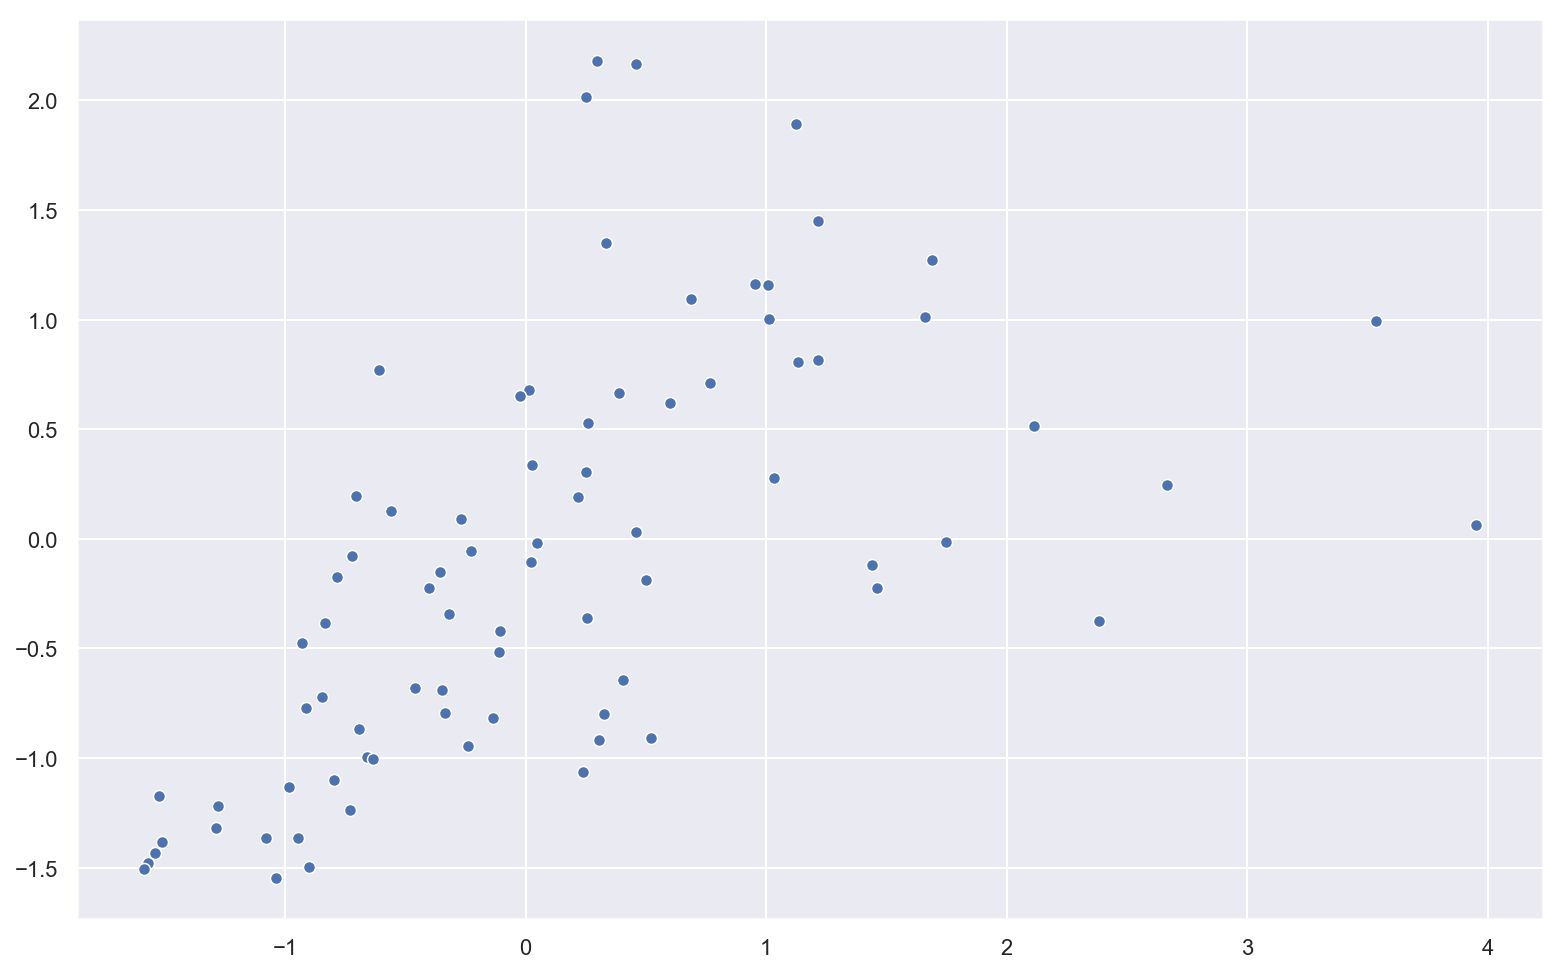

In [46]:
sns.scatterplot(list(zip(*gmm.means_))[0],list(zip(*gmm.means_))[1]);

In [47]:

y_test.values

array([2600., 5500., 1500., ..., 2500., 1700., 3500.])

In [49]:
y_hat_test =[]
y_true_test=[]

for i,observation in enumerate(X_test.values[0:1]):
    if i%100==0:
        print(i, end=" ")
    prediction,dist,prediction_index,predicted_range = pipeline.predict_with_pdf(observation[np.ix_(pipeline.given_index)])
    y_hat_test.append(prediction)
    y_true_test.append(X_test.values[i][np.ix_(pipeline.a_index)]*ss.scale_[np.ix_(pipeline.a_index)]+ss.mean_[np.ix_(pipeline.a_index)])
    #print("y_hat {} y {}".format(prediction,y_true_test[-1]))



0 

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [62]:
for i,observation in enumerate(X_test.values[0:1]):
    if i%100==0:
        print(i, end=" ")
    dist = pipeline.get_pdf(observation[np.ix_(pipeline.given_index)])
    #y_hat_test.append(prediction)
    #y_true_test.append(X_test.values[i][np.ix_(pipeline.a_index)]*ss.scale_[np.ix_(pipeline.a_index)]+ss.mean_[np.ix_(pipeline.a_index)])
    #print("y_hat {} y {}".format(prediction,y_true_test[-1]))



0 

NameError: name 'dist_range' is not defined

In [15]:
from sklearn.metrics import r2_score
r2_score(y_true_test, y_hat_test)

0.5564841258330706

In [16]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test.values, y_hat_test)#,np.mean(np.abs((y_test.values - y_hat_test) / y_test.values)) * 100

387.87794360816514

In [17]:
y_train = X_train.meter_price*pipeline.a_scales+pipeline.a_means
y_train.head()

0    1200.0
1    2300.0
2    2300.0
3    2850.0
4    1350.0
Name: meter_price, dtype: float64

In [18]:
X_train.meter_price = (X_train.meter_price- ss.mean_[3])/ss.scale_[3]

In [19]:
X_test.head()

,x,y,z,hospitals,schools,meter_price
0,0.063706,0.662906,0.285012,0.866201,1.073450,0.641863
1,0.397087,0.503154,-0.293803,-0.061381,0.126159,3.353679
2,-1.160375,-1.725404,-0.041166,-0.246897,0.674590,-0.386756
3,2.226432,1.238813,-1.359753,-1.174480,-1.618850,-1.228354
4,-0.715846,-0.064342,0.658957,0.124136,-0.023413,-0.012713


In [20]:
X_train.head()

,x,y,z,hospitals,schools,meter_price
0,-0.742036,0.145938,0.959383,-0.246897,-1.070419,-1.669305
1,-0.420859,0.103036,0.374988,1.979300,1.223022,-1.478480
2,0.402285,0.941528,0.143281,-0.432414,0.225874,-1.478480
3,0.214727,0.504346,-0.077185,0.680685,0.824163,-1.383067
4,-0.435761,0.553199,0.940753,-0.617930,-0.521987,-1.643284


In [21]:
X_train2 =X_train.drop(['meter_price'],axis=1)

In [22]:
y_hat_train =[]
y_true_train=[]
print(pipeline.given_index)
for i,observation in enumerate(X_test.values[0:10]):
    prediction,dist,prediction_index,predicted_range = pipeline.predict_with_pdf(observation[np.ix_(pipeline.given_index)])
    y_true_train.append((observation[3]*ss.scale_[3]+ss.mean_[3]))
    y_hat_train.append(prediction)
    print("{}: y_hat {} y {}".format(i,prediction,y_true_train[-1]))

[0, 1, 2]
0: y_hat [2731.97597598] y 13.0
1: y_hat [3676.21621622] y 8.0
2: y_hat [1475.3033033] y 7.0
3: y_hat [885.15315315] y 2.0
4: y_hat [1891.87987988] y 9.0
5: y_hat [1107.32732733] y 2.0
6: y_hat [1891.87987988] y 11.0
7: y_hat [1468.36036036] y 5.0
8: y_hat [1218.41441441] y 2.0
9: y_hat [1572.5045045] y 6.0


In [23]:
X_train.columns

Index(['x', 'y', 'z', 'hospitals', 'schools', 'meter_price'], dtype='object')

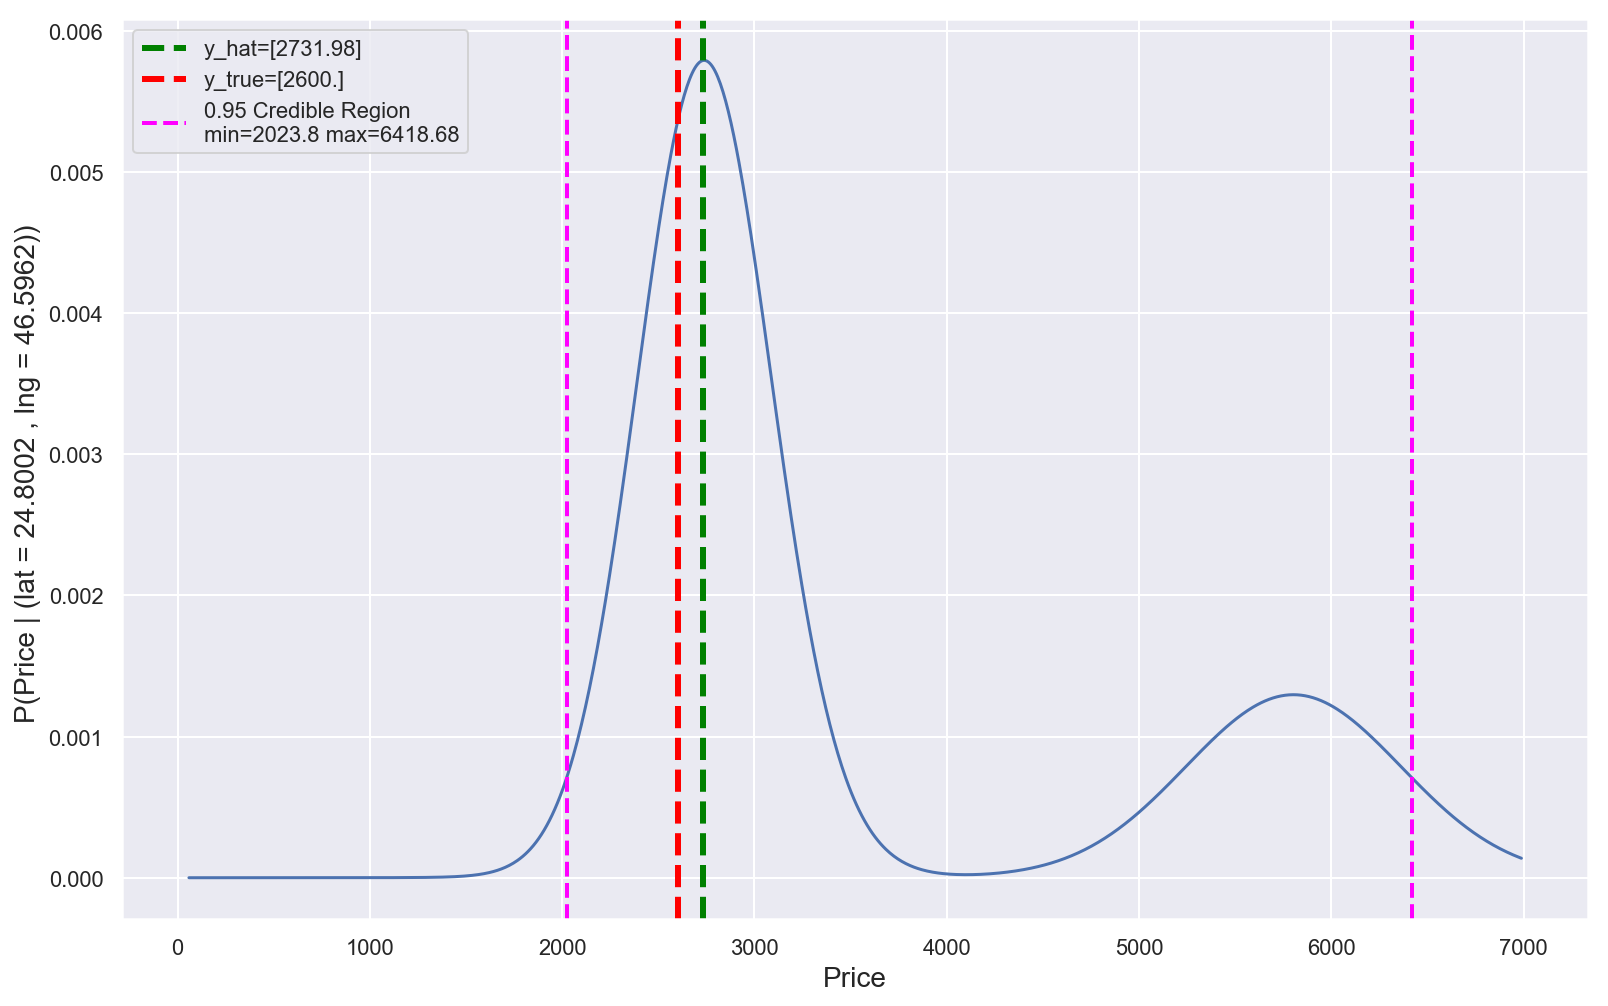

<Figure size 842.4x595.44 with 0 Axes>

In [26]:
my_dict={}
credible_region=0.95
for i, coordinate in enumerate(X_test.values[0:1]):
    is_error=False
    lat,lng = X_test_location[i].split(',')
    lat,lng= round(float(lat),4),round(float(lng),4)
    prediction,dist,prediction_index,predicted_range = pipeline.predict_with_cdf(coordinate[np.ix_(pipeline.given_index)])
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    ax=sns.lineplot(predicted_range,dist)
    
    try:
        min_credible,max_credible = pipeline.get_dist_range(predicted_range,dist,credible_region)
    
    except:
        is_error=True
        
    classification_entry ={'lat':lat,'lng':lng,'y_hat':prediction,#'distribution':dist,
                           'min_credible':min_credible,"max_credible":max_credible,
                           "credible_region":credible_region,"y_true":y_test.values[i],
                           "error":is_error,
                          "inside_credible_region": (y_test.values[i]>min_credible and y_test.values[i]<max_credible)}
    my_dict[i]=classification_entry
    
    ax.axvline(prediction, lw=3, ls='dashed', color='green',label='y_hat={}'.format(np.round(prediction,2)))
    ax.axvline(X_test.values[i][np.ix_(pipeline.a_index)]*ss.scale_[np.ix_(pipeline.a_index)]+ss.mean_[np.ix_(pipeline.a_index)], lw=3, ls='dashed', color='red',label='y_true={}'.format(X_test.values[i][np.ix_(pipeline.a_index)]*ss.scale_[np.ix_(pipeline.a_index)]+ss.mean_[np.ix_(pipeline.a_index)]))
    ax.axvline(min_credible, lw=2, ls='dashed', color='magenta',label='0.95 Credible Region\nmin={} max={}'.format(round(min_credible,2),round(max_credible,2)))
    ax.axvline(max_credible, lw=2, ls='dashed', color='magenta')
    ax.set_xlabel("{}".format(a_tag.capitalize()),fontsize=14)
    ax.set_ylabel("P({} | (lat = {} , lng = {})) ".format(a_tag.capitalize(),lat,lng),fontsize=14)
    ax.legend();
    fig = ax.get_figure();
    plt.figure();
    fig.savefig("test__{}.png".format(i)) 
    ax=None


In [17]:
my_dict2 = pd.DataFrame(my_dict).T

In [18]:
my_dict2.to_csv('price_credible_region_2019_feb_7_2.csv',index=False)